In [1]:
from IPython.display import Image
from os import chdir
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
import matplotlib


In [2]:
# read the file
file_name = "fig3"

x_range = 0
y_range = 0
simplices = []
vertice_id = 1
i = 0
for line in open("./data/"+file_name+".txt"):
    if(line[0]!='#'):
        
        if(i<=1):
            i=i+1
            continue
            
        elif(i==2):
            rank_num=[] # sizes of generating sets
            for j in line.split():
                rank_num.append(int(j))
            i=i+1
            #print("rank_num",rank_num)
        else:
            block = line.split(';')
            grid = block[0].split()
            grid_x = int(grid[0])
            grid_y = int(grid[1])
            
            if grid_x > x_range:
                x_range = grid_x
            if grid_y > y_range:
                y_range = grid_y
            
            if len(block)>1:
                face = block[1].split()
                for j in range(len(face)):
                    face[j] = int(face[j])
                simplices.append([grid_x,grid_y,face])
                
            else:
                simplices.append([grid_x,grid_y,[vertice_id]])
                vertice_id += 1
            i=i+1   

end_point = [x_range,y_range] #=[2,3]

# rank_num=[7,12,6]
# simplices = []
simplex_tree = []
start_id=0
for i in range(len(rank_num)-1,-1,-1):
    simplices_i=[]
    #for j in range(len(simplices)-start_id-1,len(simplices)-start_id-rank_num[i]-1,-1):
    for j in range(len(simplices)-start_id-rank_num[i],len(simplices)-start_id):
        #print("j",j)
        #print("simplices[j]",simplices[j])
        simplices_i.append(simplices[j])
    start_id += rank_num[i]
    simplex_tree.append(simplices_i)

#print("simplex_tree",simplex_tree)
    
#for i in range(len(simplices)): 
#    simplex = simplices[i]
#    face = simplex[2]    
#    if(len(face)>1):
#        print("This a %d-simplex. Its face is"%(len(face)-1),face)
#    else:
#        print("This a %d-simplex. Its index is"%(len(face)-1),face[0])
    

for i in range(1,len(simplex_tree)):
    #print(simplex_tree[i])
    for j in range(len(simplex_tree[i])):
        simplex = simplex_tree[i][j]
        #print("simplex",simplex)
        face = simplex[2]
        #print(face)
        vertices=[]
        for face_id in face:
            vert = simplex_tree[i-1][face_id-1][2]
            #print("vertex_id",vert)
            for vert_id in vert:
                if vert_id not in vertices:
                    vertices.append(vert_id)
        simplex_tree[i][j][2]=vertices
        #print("simplex_tree[i][j][2]",simplex_tree[i][j][2])



# To verify the data structur
# simplices contain all the information we need
#print("simplices:",simplices)
for i in range(len(simplex_tree)):
    for simplex in simplex_tree[i]:
        print(simplex)   

       


[0, 1, [1]]
[0, 1, [2]]
[0, 1, [3]]
[1, 0, [4]]
[1, 0, [5]]
[1, 0, [6]]
[0, 1, [1, 2]]
[0, 1, [1, 3]]
[2, 1, [1, 4]]
[2, 1, [1, 5]]
[2, 1, [1, 6]]
[0, 1, [2, 3]]
[2, 1, [2, 5]]
[2, 1, [2, 6]]
[2, 1, [3, 6]]
[1, 0, [4, 5]]
[1, 0, [4, 6]]
[1, 0, [5, 6]]
[2, 1, [1, 2, 5]]
[2, 1, [1, 3, 6]]
[2, 1, [1, 4, 5]]
[2, 1, [1, 4, 6]]
[2, 1, [2, 3, 6]]
[2, 1, [2, 5, 6]]
[1, 2, [4, 5, 6]]


## Compute rank invariant

In [3]:
def create_stair(elbow, end_point):
    # stair a path passing through the elbow.
    stair = []
    
    if(elbow[0]==0 or elbow[1]==end_point[1]):
        for i in range(end_point[1]+1):
            stair.append([0,i])
        for j in range(1,end_point[0]+1):
            stair.append([j,i])
    else:
        for i in range(elbow[1]+1):
            stair.append([0,i])   # i=0
        for j in range(elbow[0]):
            stair.append([j+1,i]) # j=0
        for k in range(i+1, end_point[1]+1):
            stair.append([j+1,k]) # k=2,3
        for l in range(j+2, end_point[0]+1):
            stair.append([l,k])
    return stair

def compute_rk(i,j,k,l,barcodes):
# This function computes the value rank(s,t) where s=(i,j) and t = (k,l)
    if(i>k or j>l):
        return 0
    
    s_1 = i + j
    t_1 = k + l
    rank0_inv = 0
    rank1_inv = 0

    for barcode in barcodes:
        if(barcode[0]==0):
            if(barcode[1][0]<=s_1 and barcode[1][1]>t_1):
                rank0_inv = rank0_inv + 1
        elif(barcode[0]==1):
            if(barcode[1][0]<=s_1 and barcode[1][1]>t_1):
                rank1_inv = rank1_inv + 1

    #return rank0_inv
    return rank1_inv

In [4]:
rank_inv = np.array(np.zeros((x_range+1,y_range+1,x_range+1,y_range+1)))

st = gd.SimplexTree()
# st.assign_filtration([3], filtration = 0.8)

#Scan all the elbows
for i in range(x_range+1):
    for j in range(y_range+1):
        elbow = [i,j]
        stair = create_stair(elbow, end_point)
        #print("stair",stair)

        # Build the simplex tree
        #for simplex in simplices:
        #    for grid_id in stair:
        #        if simplex[0]<=grid_id[0] and simplex[1]<=grid_id[1]:
        #            filtration_value = grid_id[0]+grid_id[1]
        #            if((st.insert(simplex[2], filtration = filtration_value))==False): #TODO:optimize with C++, we don
        #                st.assign_filtration(simplex[2], filtration = filtration_value)
        #            break
        for i in range(len(simplex_tree)):
            for simplex in simplex_tree[i]:
                for grid_id in stair:
                    if simplex[0]<=grid_id[0] and simplex[1]<=grid_id[1]:
                        filtration_value = grid_id[0]+grid_id[1]
                        if((st.insert(simplex[2], filtration = filtration_value))==False): #TODO:optimize with C++, we don
                            st.assign_filtration(simplex[2], filtration = filtration_value)
                        break
        
        st_gen = st.get_filtration() 
        #for splx in st_gen :
        #    print(splx)
        
        barcodes = st.persistence()
        #print("barcodes,",barcodes)
        
        for start_id in range(len(stair)):
            for end_id in range(start_id,len(stair)):
                grid_start = stair[start_id]
                grid_end = stair[end_id]
                [i,j,k,l]=[grid_start[0],grid_start[1],grid_end[0],grid_end[1]]
                rank_inv[i,j,k,l]=compute_rk(i,j,k,l,barcodes)
                #print("rank(({0},{1}),({2},{3}))={4}".format(i,j,k,l,int(rank_inv[i,j,k,l])))
                
                
#for i in range(x_range+1):
#    for j in range(y_range+1):
#        for k in range(x_range+1):
#            for l in range(y_range+1):
#                print("rank(({0},{1}),({2},{3}))={4}".format(i,j,k,l,int(rank_inv[i,j,k,l])))

        


In [5]:
#Now it's rank0_invariance
np.save("./result/rank1_invariance_for_"+file_name,rank_inv)
for i in range(x_range+1):
    for j in range(y_range+1):
        for k in range(i,x_range+1):
            for l in range(j,y_range+1):
                print("rank(({0},{1}),({2},{3}))={4}".format(i,j,k,l,int(rank_inv[i,j,k,l])))

        

rank((0,0),(0,0))=0
rank((0,0),(0,1))=0
rank((0,0),(0,2))=0
rank((0,0),(1,0))=0
rank((0,0),(1,1))=0
rank((0,0),(1,2))=0
rank((0,0),(2,0))=0
rank((0,0),(2,1))=0
rank((0,0),(2,2))=0
rank((0,1),(0,1))=1
rank((0,1),(0,2))=1
rank((0,1),(1,1))=1
rank((0,1),(1,2))=1
rank((0,1),(2,1))=1
rank((0,1),(2,2))=0
rank((0,2),(0,2))=1
rank((0,2),(1,2))=1
rank((0,2),(2,2))=0
rank((1,0),(1,0))=1
rank((1,0),(1,1))=1
rank((1,0),(1,2))=0
rank((1,0),(2,0))=1
rank((1,0),(2,1))=1
rank((1,0),(2,2))=0
rank((1,1),(1,1))=2
rank((1,1),(1,2))=1
rank((1,1),(2,1))=1
rank((1,1),(2,2))=0
rank((1,2),(1,2))=1
rank((1,2),(2,2))=0
rank((2,0),(2,0))=1
rank((2,0),(2,1))=1
rank((2,0),(2,2))=0
rank((2,1),(2,1))=1
rank((2,1),(2,2))=0
rank((2,2),(2,2))=0


## compute multiplicity

In [6]:
#
#m((i,j),(k,l))
def multp(rank, i,j,k,l):
    if(i<0 or j<0 or k>rank.shape[1] or l>rank.shape[0]):   
        return 0
    
    res = rank[i,j,k,l]
    if(k+1<rank.shape[0]):
        res -= rank[i,j,k+1,l]
    if(l+1<rank.shape[1]):
        res -= rank[i,j,k,l+1]
    if(k+1<rank.shape[0] and l+1<rank.shape[1]):
        res += rank[i,j,k+1,l+1]
    
    return res
    

def compute_R_S_incl_excl(rank):
    multiplicity = np.zeros_like(rank)
    for i in range(rank.shape[0]):
        for j in range(rank.shape[1]):
            for k in range(i,rank.shape[0]):
                for l in range(j,rank.shape[1]):
                    m = multp(rank,i,j,k,l)-multp(rank,i-1,j,k,l)-multp(rank,i,j-1,k,l)+multp(rank,i-1,j-1,k,l)
                    if(m!=0):
                        multiplicity[i,j,k,l] = m
    return multiplicity
    

In [7]:
m = compute_R_S_incl_excl(rank_inv)

np.save("./result/rank1_multiplicity_for_"+file_name,m)

### Draw grid for multiplicity

(3, 3, 3, 3)
0 0 0 0 0.0
0 0 0 1 0.0
0 0 0 2 0.0
0 0 1 0 0.0
0 0 1 1 0.0
0 0 1 2 0.0
0 0 2 0 0.0
0 0 2 1 0.0
0 0 2 2 0.0
0 1 0 1 0.0
0 1 0 2 0.0
0 1 1 1 -1.0
0 1 1 2 1.0
0 1 2 1 1.0
0 1 2 2 0.0
0 2 0 2 0.0
0 2 1 2 0.0
0 2 2 2 0.0
1 0 1 0 0.0
1 0 1 1 0.0
1 0 1 2 0.0
1 0 2 0 0.0
1 0 2 1 1.0
1 0 2 2 0.0
1 1 1 1 1.0
1 1 1 2 0.0
1 1 2 1 -1.0
1 1 2 2 0.0
1 2 1 2 0.0
1 2 2 2 0.0
2 0 2 0 0.0
2 0 2 1 0.0
2 0 2 2 0.0
2 1 2 1 0.0
2 1 2 2 0.0
2 2 2 2 0.0


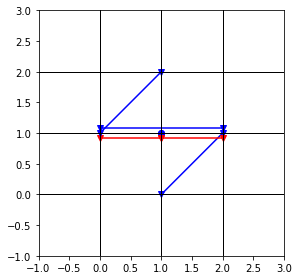

In [28]:
data = np.ones((x_range,y_range)) * np.nan

fig, ax = plt.subplots(1, 1, tight_layout=True)
for x in range(x_range+1):
    ax.axvline(x, lw=1, color='k', zorder=5) # Horizontal 
for y in range(y_range+1):
    ax.axhline(y, lw=1, color='k', zorder=5) # Ordinate
print(m.shape)

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        for k in range(i,m.shape[0]):
            for l in range(j,m.shape[1]):
                print(i,j,k,l,m[i,j,k,l])
                if(m[i,j,k,l]>0):
                    #print(i,j,k,l,m[i,j,k,l])
                    if(i==k and j==l):
                        ax.plot([i, k], [j, l],'bo', linestyle="-")
                    elif(i==k):
                        ax.plot([i+0.08, k+0.08], [j, l],'bv', linestyle="-")
                    elif(j==l):
                        ax.plot([i, k], [j+0.08, l+0.08],'bv',linestyle="-")
                    else:  
                        ax.plot([i, k], [j, l],'bv', linestyle="-")
                if(m[i,j,k,l]<0):
                    #print(i,j,k,l,m[i,j,k,l])
                    if(i==k and j==l):
                        ax.plot([i, k], [j, l],'ro', linestyle="-")
                    elif(i==k):
                        ax.plot([i-0.08, k-0.08], [j, l],'rv', linestyle="-")
                        #ax.plot([i, k], [j, l],'rv', linestyle="-")
                    elif(j==l):
                        ax.plot([i, k], [j-0.08, l-0.08],'rv', linestyle="-")
                        #ax.plot([i, k], [j, l],'rv', linestyle="-")
                    else:  
                        ax.plot([i, k], [j, l], 'rv', linestyle="-")

ax.imshow(data, interpolation='none', extent=[-1,x_range+1, -1, y_range+1], zorder=0)

#ax.axis('off')